In [107]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, math, os, sys

from typing import List, Tuple, Dict, Literal, Set

In [139]:
df = pd.read_csv('single_blink.csv')

In [140]:
SENSORS = ['TP9', 'AF7', 'AF8', 'TP10']

In [141]:
def count_from_right_vectorized(arr, mask):
    """
    Count consecutive True values from the right of the mask.
    """
    # Reverse the mask to count from right
    reversed_mask = mask[::-1]
    
    # Find first False (if any)
    false_indices = np.where(reversed_mask == False)[0]
    
    if len(false_indices) == 0:
        # All elements satisfy the condition
        return len(arr)
    else:
        # Return count of consecutive True values from right
        return false_indices[0]


def find_triggers(buffer: np.ndarray, current: float, min_stds: float = 2.0, 
                  window_size: int = 1000, trigger_cutoff: int = 5) -> None | Tuple[int, str]:
    """
    Returns None or (frames ago trigger started, trigger type)
    
    This function matches the plot_sensors logic by:
    1. Using rolling stats to compute dynamic thresholds
    2. Checking if current value exceeds threshold
    3. Looking back to find start of continuous violation
    """
    
    # Compute rolling statistics (matches plot_sensors)
    r_mean, r_std = rolling_stats(buffer, window_size=window_size)
    
    # Compute threshold bounds
    pos_cutoff = r_mean + r_std * min_stds
    neg_cutoff = r_mean - r_std * min_stds
    
    # Check if current value (last value in buffer) exceeds thresholds
    current_pos_threshold = pos_cutoff[-1]
    current_neg_threshold = neg_cutoff[-1]
    
    # Find since when, look back max 50 frames
    mflb: int = 100
    len_of_trigger: int = 0
    trigger_type: str = None
    
    # Determine if we have a trigger
    if current < current_neg_threshold:
        # Negative trigger detected - look back to find start
        detection_area = buffer[-mflb:]
        cutoff_area = neg_cutoff[-mflb:]
        
        # Create mask: True where value is below cutoff (trigger condition)
        mask = detection_area < cutoff_area
        
        len_of_trigger = count_from_right_vectorized(detection_area, mask)
        trigger_type = 'down'
        
    elif current > current_pos_threshold:
        # Positive trigger detected - look back to find start
        detection_area = buffer[-mflb:]
        cutoff_area = pos_cutoff[-mflb:]
        
        # Create mask: True where value is above cutoff (trigger condition)
        mask = detection_area > cutoff_area
        
        len_of_trigger = count_from_right_vectorized(detection_area, mask)
        trigger_type = 'up'
    else:
        # No trigger on this frame
        return None
    
    # If trigger length not good then return
    if len_of_trigger < trigger_cutoff:
        return None
        
    return (len_of_trigger, trigger_type)


def rolling_stats(data, window_size, min_std: float = 10.0):
    """
    Calculate rolling mean and std using convolution.
    This matches the logic in plot_sensors.
    """
    kernel = np.ones(window_size) / window_size

    # Pad kernel so we only look at past examples
    kernel = np.pad(kernel, (0, window_size - 1), mode='constant', constant_values=0)
    
    # Calculate rolling mean
    mean = np.convolve(data, kernel, mode='same')
    
    # Calculate rolling std
    data_squared = data ** 2
    mean_squared = np.convolve(data_squared, kernel, mode='same')
    std = np.sqrt(np.maximum(mean_squared - mean ** 2, 0))  # Avoid negative values from numerical errors
    std[std < min_std] = min_std
    
    return mean, std


def handle_frame(band_buffers: np.ndarray, timestamps: np.ndarray, current: np.ndarray, 
                 min_stds: float = 2.0, window_size: int = 1000, 
                 trigger_cutoff: int = 5) -> List[Tuple[float, float, int, str, str]]:
    """
    Process a frame and detect triggers across all sensors.
    
    Args:
        band_buffers (np.ndarray): Buffer of historical sensor data (shape: n_sensors x window_size)
        timestamps (np.ndarray): Corresponding timestamps
        current (np.ndarray): Current sensor readings
        min_stds (float, optional): Number of standard deviations for threshold. Defaults to 2.0.
        window_size (int, optional): Rolling window size. Defaults to 1000.
        trigger_cutoff (int, optional): Minimum frames for valid trigger. Defaults to 5.
    
    Returns:
        List[Tuple[float, float, int, str, str]]: (start ts, end ts, #frames, sensor name, type)
    """
    frame_triggers = []
    
    # Loop over SENSORS
    for (s, buffer, c) in zip(SENSORS, band_buffers, current):
        t = find_triggers(buffer, c, min_stds=min_stds, 
                         window_size=window_size, trigger_cutoff=trigger_cutoff)
        if t:
            # Calculate start and end timestamps
            # t[0] is the number of frames back where trigger started
            start_time = timestamps[-t[0]].item()
            end_time = timestamps[-1].item()
            emitted_event = (start_time, end_time, t[0], s, t[1])
            frame_triggers.append(emitted_event)
    
    return frame_triggers


# Test function to verify alignment with plot
def verify_trigger_alignment(df, trigger_events, r=slice(0, -1), 
                             history_len=500, trigger_stds=2.0):
    """
    Verify that trigger events align with plot annotations.
    Returns a comparison report.
    """
    results = []
    
    for sensor in SENSORS:
        # Get rolling stats (same as plot)
        data = df[sensor].to_numpy()[r]
        mean, std = rolling_stats(data, window_size=history_len)
        
        pos_cutoff = mean + std * trigger_stds
        neg_cutoff = mean - std * trigger_stds
        
        # Find violations in plot
        up_violations = data > pos_cutoff
        down_violations = data < neg_cutoff
        
        # Get trigger events for this sensor
        sensor_triggers = [e for e in trigger_events if e[3] == sensor]
        
        results.append({
            'sensor': sensor,
            'plot_up_count': up_violations.sum(),
            'plot_down_count': down_violations.sum(),
            'trigger_count': len(sensor_triggers),
            'triggers': sensor_triggers
        })
    
    return results

In [142]:
def plot_sensors(
    data: pd.DataFrame, 
    r: slice = slice(0, -1), 
    history_len: int = 200, 
    trigger_stds: float = 2.0, 
    min_trigger_len: int = 5, 
    min_stretch_gap: int = 10,
    show_annotations: bool = True,
    show_highlights: bool = True,
    trigger_events: List[Tuple[float, float, int, str, str]] = None
) -> 'Axis':
    """
    Plot sensor data with anomaly detection and optional trigger event highlighting.
    
    Args:
        data: DataFrame with sensor data
        r: slice for data range
        history_len: window size for rolling stats
        trigger_stds: number of standard deviations for trigger bounds
        min_trigger_len: minimum length for annotation
        min_stretch_gap: minimum gap between stretches
        show_annotations: whether to show anomaly annotations
        show_highlights: whether to highlight anomalies
        trigger_events: List of (start_ts, end_ts, n_frames, sensor_name, trigger_type)
                       from find_triggers function
    
    Returns:
        Array of matplotlib axes
    """
    
    fig, axs = plt.subplots(len(SENSORS), 1, figsize=(12, 2.5 * len(SENSORS)))
    
    axs = axs.flatten()

    sensor_trigger_history = []

    # Generate trigger bounds
    for s in SENSORS:
        mean, std = rolling_stats(
                data[s].to_numpy()[r], window_size=history_len
            )

        sensor_trigger_history.append(
            (
                mean - std * trigger_stds, mean + std * trigger_stds
            )
        )

    # Adjust time stamps to zero
    ts = data['timestamps'][r] - data['timestamps'][r].min()
    
    # Color palette for different sensors
    colors = plt.cm.tab10(range(len(SENSORS)))
    
    # Organize trigger events by sensor if provided
    sensor_triggers = {s: [] for s in SENSORS}
    if trigger_events:
        for start_ts, end_ts, n_frames, sensor_name, trigger_type in trigger_events:
            if sensor_name in sensor_triggers:
                sensor_triggers[sensor_name].append({
                    'start': start_ts,
                    'end': end_ts,
                    'frames': n_frames,
                    'type': trigger_type
                })
    
    for i, (s, sh, ax) in enumerate(zip(SENSORS, sensor_trigger_history, axs)):

        d = data[s][r]

        up_highlight = np.full_like(d, fill_value=np.nan)
        down_highlight = np.full_like(d, fill_value=np.nan)

        # Highlight sections outside of bounds
        min_b, max_b = sh

        up_highlight[max_b < d] = d[max_b < d]
        down_highlight[min_b > d] = d[min_b > d]
        
        ax.plot(
            ts,
            d,
            color=colors[i],
            linewidth=2,
            alpha=0.8
        )

        ax.plot(ts, min_b, color='red', alpha=0.5, linestyle='--', linewidth=1)
        ax.plot(ts, max_b, color='blue', alpha=0.5, linestyle='--', linewidth=1)

        # Plot green highlights (optional)
        if show_highlights:
            ax.plot(ts, up_highlight, color='green', linewidth=2.5)
            ax.plot(ts, down_highlight, color='green', linewidth=2.5)
        
        # Highlight trigger events with vertical spans
        if trigger_events and sensor_triggers[s]:
            for trigger in sensor_triggers[s]:
                # Adjust trigger timestamps to match the zero-adjusted plot timestamps
                trigger_start = trigger['start'] - data['timestamps'][r].min()
                trigger_end = trigger['end'] - data['timestamps'][r].min()
                
                # Choose color based on trigger type
                span_color = 'red' if trigger['type'] == 'up' else 'blue'
                span_alpha = 0.2
                
                # Add vertical span for trigger duration
                ax.axvspan(trigger_start, trigger_end, 
                          color=span_color, alpha=span_alpha, 
                          label=f'Trigger ({trigger["type"]})')
                
                # Add vertical line at trigger start with annotation
                ax.axvline(trigger_start, color=span_color, 
                          linestyle=':', linewidth=2, alpha=0.7)
                
                # Add text annotation for trigger
                y_pos = ax.get_ylim()[1] * 0.95 if trigger['type'] == 'up' else ax.get_ylim()[0] * 1.05
                ax.text(trigger_start, y_pos,
                       f'🔔 {trigger["frames"]}f',
                       fontsize=10,
                       fontweight='bold',
                       color=span_color,
                       ha='left',
                       va='top' if trigger['type'] == 'up' else 'bottom',
                       bbox=dict(boxstyle='round,pad=0.4', 
                                facecolor='yellow', 
                                edgecolor=span_color, 
                                alpha=0.9,
                                linewidth=2))
        
        # Add annotations (optional)
        if show_annotations:
            # Find continuous stretches of non-NaN values
            def find_stretches(highlight_array, min_len, min_gap):
                """Find continuous stretches of non-NaN values >= min_len"""
                stretches = []
                start = None
                
                for i in range(len(highlight_array)):
                    if not np.isnan(highlight_array[i]):
                        if start is None:
                            start = i
                    else:
                        if start is not None:
                            length = i - start
                            if length >= min_len:
                                stretches.append((start, i - 1, length))
                            start = None
                
                # Handle case where stretch extends to end
                if start is not None:
                    length = len(highlight_array) - start
                    if length >= min_len:
                        stretches.append((start, len(highlight_array) - 1, length))
                
                # Filter out stretches that are too close together
                if len(stretches) <= 1:
                    return stretches
                
                filtered_stretches = [stretches[0]]
                for start_idx, end_idx, length in stretches[1:]:
                    prev_end = filtered_stretches[-1][1]
                    # Check if gap between previous stretch end and current stretch start is large enough
                    if start_idx - prev_end >= min_gap:
                        filtered_stretches.append((start_idx, end_idx, length))
                    else:
                        # Merge with previous stretch if too close
                        prev_start = filtered_stretches[-1][0]
                        new_length = end_idx - prev_start + 1
                        filtered_stretches[-1] = (prev_start, end_idx, new_length)
                
                return filtered_stretches
            
            # Add tags for upper threshold violations
            up_stretches = find_stretches(up_highlight, min_trigger_len, min_stretch_gap)
            for start_idx, end_idx, length in up_stretches:
                ax.text(
                    ts.iloc[start_idx], 
                    d.iloc[start_idx],
                    f'▲ HIGH ({length})',
                    fontsize=9,
                    fontweight='bold',
                    color='darkred',
                    ha='left',
                    va='bottom',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='red', alpha=0.8)
                )
            
            # Add tags for lower threshold violations
            down_stretches = find_stretches(down_highlight, min_trigger_len, min_stretch_gap)
            for start_idx, end_idx, length in down_stretches:
                ax.text(
                    ts.iloc[start_idx],
                    d.iloc[start_idx],
                    f'▼ LOW ({length})',
                    fontsize=9,
                    fontweight='bold',
                    color='darkblue',
                    ha='left',
                    va='top',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='blue', alpha=0.8)
                )
        
        # Styling
        ax.set_ylabel(s, fontsize=11, fontweight='bold')
        ax.set_xlabel('Time (s)' if i == len(SENSORS) - 1 else '', fontsize=10)
        ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Format x-axis for better readability
        ax.tick_params(axis='both', labelsize=9)
        
    title = 'Sensor Data with Anomaly Detection'
    if trigger_events:
        title += f' ({len(trigger_events)} triggers detected)'
    plt.suptitle(title, fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    return axs

In [143]:
# Hash with starting ts and sensor
check_events: Dict[Tuple[float, str], Tuple] = {}

for start in range(1000):

    buffers = df[SENSORS].to_numpy().T[:, start : start + 1001]
    timestamps = df['timestamps'].to_numpy()[start : start + 1001]

    e = handle_frame(buffers[:, 0: 1000], timestamps, buffers[:, -1].reshape((-1,)))

    for ei in e:

        check_events[(ei[0], ei[4])] = ei

len(check_events)

18

In [144]:
check_events

{(1759592709.532, 'down'): (1759592709.532,
  1759592709.579,
  np.int64(13),
  'AF7',
  'down'),
 (1759592709.591, 'down'): (1759592709.591,
  1759592709.653,
  np.int64(17),
  'AF7',
  'down'),
 (1759592709.689, 'down'): (1759592709.689,
  1759592709.704,
  np.int64(5),
  'AF7',
  'down'),
 (1759592709.724, 'down'): (1759592709.724,
  1759592709.841,
  np.int64(31),
  'AF7',
  'down'),
 (1759592709.818, 'down'): (1759592709.818,
  1759592709.833,
  np.int64(5),
  'AF8',
  'down'),
 (1759592709.825, 'down'): (1759592709.825,
  1759592709.857,
  np.int64(9),
  'TP10',
  'down'),
 (1759592709.853, 'down'): (1759592709.853,
  1759592710.028,
  np.int64(46),
  'AF7',
  'down'),
 (1759592709.872, 'down'): (1759592709.872,
  1759592709.888,
  np.int64(5),
  'TP10',
  'down'),
 (1759592710.04, 'down'): (1759592710.04,
  1759592710.071,
  np.int64(9),
  'AF7',
  'down'),
 (1759592710.083, 'down'): (1759592710.083,
  1759592710.341,
  np.int64(67),
  'AF7',
  'down'),
 (1759592710.345, 'down')

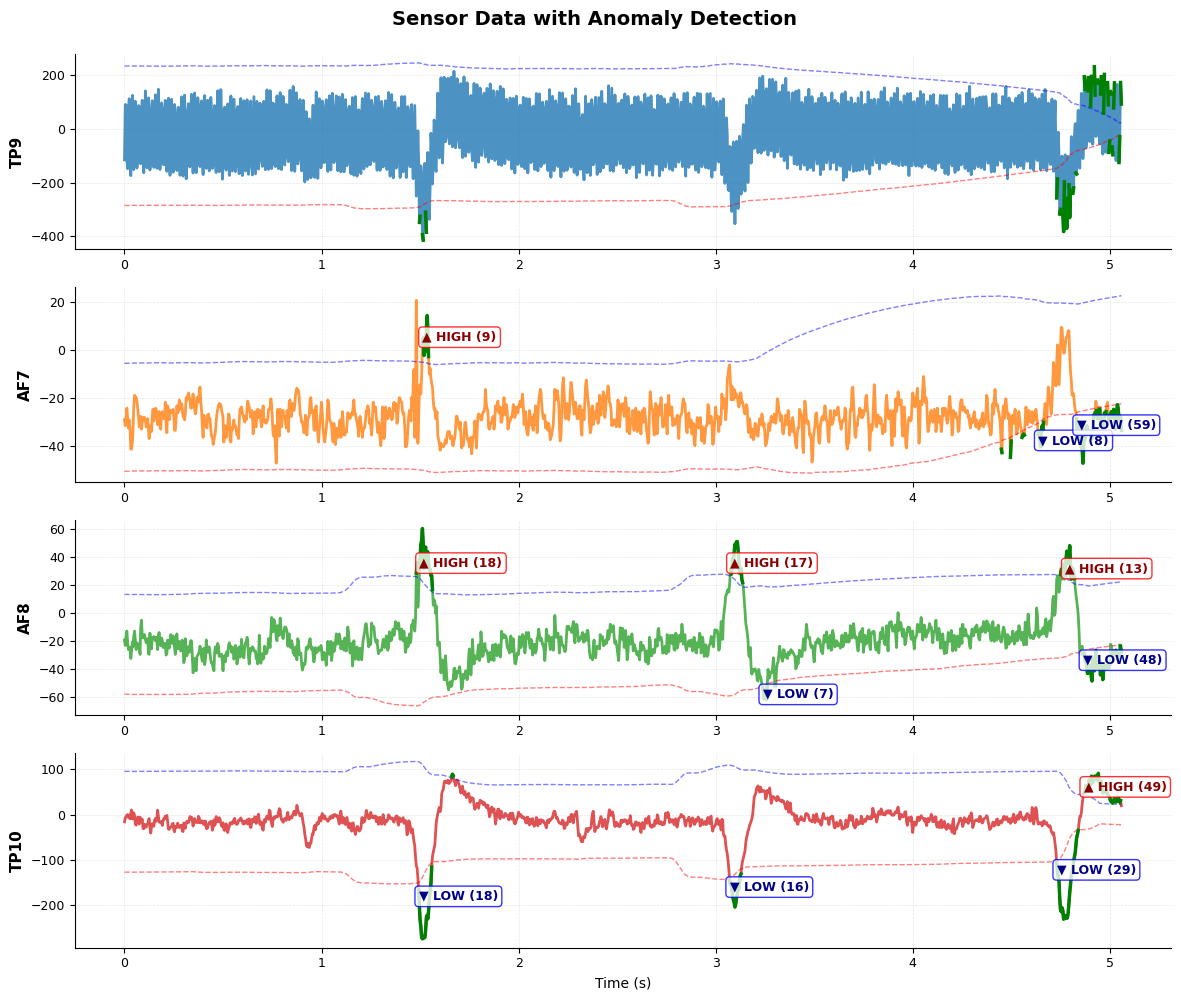

In [149]:
start: int = 0
bound: int = 10000

axs = plot_sensors(df, r=slice(start, start + bound), history_len=500, trigger_stds=2.25) #, trigger_events=list(check_events.values()))

In [ ]:
fig = axs[0].get_figure()
fig.savefig('sensor_plot.png', dpi=300, bbox_inches='tight')